# Package

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor 
from sklearn.linear_model import Lasso
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score
import pickle

In [24]:
def plot_target_pred(y, y_pred, target_next):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4.5))
    target_next_pred = target_next+'_pred'
    ax1.plot(y, 'b-', label=target_next)
    ax1.plot(y_pred, 'r-.', label=target_next_pred)
    ax1.legend()
    target_next_pred = target_next+'_pred'
    ax2.plot(y, y_pred, '.')
    ax2.set_xlabel(target_next)
    ax2.set_ylabel(target_next_pred)
    ax2.legend()
    plt.tight_layout()
    plt.show() 

In [2]:
class Stacking:
    
    def __init__(self, x_train, y_train, x_test, y_test, ls_model_stack, model_final, type_label):
        self.trainx = x_train
        self.trainy = y_train
        self.testx = x_test
        self.testy = y_test
        self.ls_model_stack = ls_model_stack
        self.model_final = model_final
        self.type_label = type_label
        self.trainx_stacking_input = None
        self.trainy_stacking = None
        self.trainx_final = None
        self.trainy_final = None
        self.trainx_final_input = None
        self.testx_final_input = np.zeros((x_test.shape[0], len(ls_model_stack)))
    
    def spliting(self):
        if self.type_label == 'discrete':
            self.trainx_stacking_input, self.trainx_final, self.trainy_stacking, self.trainy_final = train_test_split (self.trainx, self.trainy, test_size= 0.3, random_state = 42, stratify = self.trainy)
        elif self.type_label == 'continuous':
            self.trainx_stacking_input, self.trainx_final, self.trainy_stacking, self.trainy_final = train_test_split (self.trainx, self.trainy, test_size= 0.3, random_state = 42)
        self.trainx_final_input = np.zeros((self.trainx_final.shape[0], len(self.ls_model_stack)))   
    
    def modeling_stack_training(self):
        for model, i in zip(self.ls_model_stack, range(len(self.ls_model_stack))):
            model.fit(self.trainx_stacking_input, self.trainy_stacking)
            output = model.predict(self.trainx_final)
            self.trainx_final_input[:, i] = output
            self.save_model(model, 'stacking_model' + str(i))
            
    def modeling_final_training(self):
        self.model_final.fit(self.trainx_final_input, self.trainy_final)
        self.save_model(self.model_final, 'stacking_final')
        
    def predict_stack_testing(self):
        for model, i in zip(self.ls_model_stack, range(len(self.ls_model_stack))):
            output = model.predict(self.testx)
            self.testx_final_input[:, i] = output
    
    def predict_final_testing(self):
        self.testy_pred = self.model_final.predict(self.testx_final_input)
        if self.type_label == 'discrete':
            self.testy_pred_prob=self.model_final.predict_proba(self.testx_final_input)
            return self.testy_pred, self.testy_pred_prob
        return self.testy_pred
    
    def scoring_testing(self):
        if self.type_label == 'discrete':
            fpr, tpr, thresholds = roc_curve(self.testy, self.testy_pred_prob[:, 1], pos_label=None)
            AUC=auc(fpr, tpr)
            return AUC
        elif self.type_label == 'continuous':
            r2 = r2_score(self.testy, self.testy_pred)
            return r2
    
    def save_model(self, model, filename):
        pickle.dump(model, open(filename, 'wb'))

# Data

In [3]:
file_path = r'C:\Users\user\Desktop\git_hub\finished\ml\kaggle房價預測\data\train_processing.csv'
data = pd.read_csv(file_path, encoding="Big5", low_memory=False, index_col=0)

In [4]:
data_v1 = data.copy()

In [5]:
X = data_v1.drop("SalePrice", axis=1).values
y = data_v1["SalePrice"].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Stacking

將調參過的所有模型做stacking。集成的模型包含XGBoost、LightGBM、AdaBoost、Random Forest、MLP、SVM、Lasso Regression (以上均調參過)，因為Decision Tree調參的表現低於其他模型較多所以並沒有放進stacking中。Fianl Model為Lasso Regression。

In [6]:
dt_pip = make_pipeline(StandardScaler(),
                       PCA(n_components = 50),
                       DecisionTreeRegressor(max_depth = 8))
rf_pip = make_pipeline(StandardScaler(),
                       PCA(n_components = 100),
                       RandomForestRegressor(max_depth = 8))
ada_pip = make_pipeline(StandardScaler(),
                        PCA(n_components = 50),
                        AdaBoostRegressor(n_estimators = 300, learning_rate = 0.1))
ls_pip = make_pipeline(MinMaxScaler(),
                       PCA(n_components = 100),
                       Lasso(normalize = False, alpha = 0.1))
mlp_pip = make_pipeline(Normalizer(), 
                        PCA(n_components = 100), 
                        MLPRegressor(activation = 'relu', alpha = 0.01, batch_size = 'auto', 
                                     hidden_layer_sizes = (64, 64), learning_rate = 'constant', 
                                     learning_rate_init = 0.1, max_iter = 200, solver = 'adam'))
xgb_pip = make_pipeline(StandardScaler(),
                        PCA(n_components = 100),
                        xgb.XGBRegressor(learning_rate = 0.1, colsample_bytree = 0.7,
                                         gamma = 0.1, max_depth = 4, min_child_weight = 1))
svm_pip = LinearSVR(C = 0.01)
lgb_pip = lgb.LGBMRegressor(reg_lambda = 0.01, learning_rate = 0.1, max_depth = 6, 
                            min_child_samples = 16, reg_alpha = 0.1)

In [7]:
model_stack = [rf_pip, ada_pip, ls_pip, mlp_pip, xgb_pip, svm_pip, lgb_pip]
model_final = Lasso()
type_label = 'continuous'

In [8]:
stacking = Stacking(X_train, y_train, X_test, y_test, model_stack, model_final, type_label)
stacking.spliting()
stacking.modeling_stack_training()
stacking.modeling_final_training()
stacking.predict_stack_testing()
stacking.predict_final_testing()
stacking.scoring_testing()

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exampl

0.9032827271995842

No handles with labels found to put in legend.


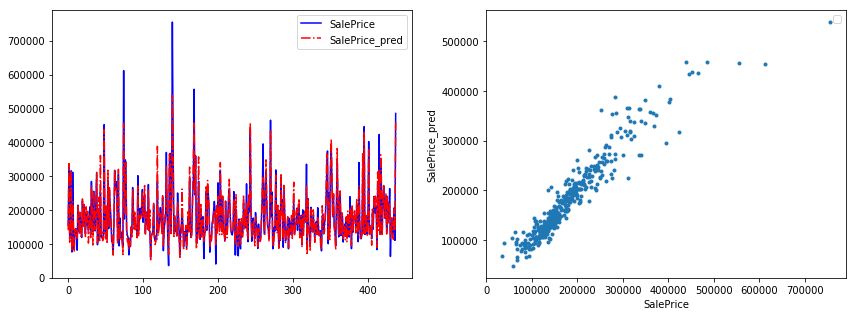

In [27]:
y_test_pred = stacking.predict_final_testing()
plot_target_pred(y_test, y_test_pred, 'SalePrice')

In [9]:
r2_stacking = stacking.scoring_testing()

# Comparison of Model Performance

AdaBoost

In [14]:
file_ada = r'C:\Users\user\Desktop\git_hub\finished\ml\kaggle房價預測\data\SearchCV_AdaBoost'
ada = pickle.load(open(file_ada,'rb')) 
r2_ada = ada.score(X_test, y_test) 

Random Forest

In [15]:
file_rf = r'C:\Users\user\Desktop\git_hub\finished\ml\kaggle房價預測\data\SearchCV_RandomForest'
rf = pickle.load(open(file_rf,'rb')) 
r2_rf = rf.score(X_test, y_test) 

Lasso Regression

In [16]:
file_ls = r'C:\Users\user\Desktop\git_hub\finished\ml\kaggle房價預測\data\SearchCV_Lasso'
ls = pickle.load(open(file_ls,'rb')) 
r2_ls = ls.score(X_test, y_test) 

MLP Regressor

In [17]:
file_mlp = r'C:\Users\user\Desktop\git_hub\finished\ml\kaggle房價預測\data\SearchCV_MLP'
mlp = pickle.load(open(file_mlp,'rb')) 
r2_mlp = mlp.score(X_test, y_test) 

XGBoost

In [18]:
file_xgb = r'C:\Users\user\Desktop\git_hub\finished\ml\kaggle房價預測\data\SearchCV_XGBoost'
xgb = pickle.load(open(file_xgb,'rb')) 
r2_xgb = xgb.score(X_test, y_test) 

SVM

In [19]:
file_svm = r'C:\Users\user\Desktop\git_hub\finished\ml\kaggle房價預測\data\SearchCV_SVM'
svm = pickle.load(open(file_svm,'rb')) 
r2_svm = svm.score(X_test, y_test) 

LightGBM

In [20]:
file_gbm = r'C:\Users\user\Desktop\git_hub\finished\ml\kaggle房價預測\data\SearchCV_GBM'
gbm = pickle.load(open(file_gbm,'rb')) 
r2_gbm = gbm.score(X_test, y_test) 

### Records

In [23]:
records = pd.DataFrame({
                        'Model': [
                                  'LightGBM',
                                  'Lasso Regression', 
                                  'Random Forest Regressor',  
                                  'Adaptive Boosting (AdaBoost)',
                                  'Extreme Gradient Boosting (XGBoost)',
                                  'MLP Regressor',
                                  'Stacking',
                                  'SVM'],
                        'R2_test': [
                                    r2_gbm,
                                    r2_ls, 
                                    r2_rf,  
                                    r2_ada,  
                                    r2_xgb,
                                    r2_mlp,
                                    r2_stacking,
                                    r2_svm]})

records['R2_test']=round(records['R2_test'], 4).values
records.sort_values(by = 'R2_test', ascending = False, inplace = True)
records.index = range(1, records.shape[0] + 1)
records

,Model,R2_test
1,Stacking,0.9033
2,LightGBM,0.9007
3,Extreme Gradient Boosting (XGBoost),0.9003
4,Random Forest Regressor,0.8822
5,MLP Regressor,0.8703
6,Adaptive Boosting (AdaBoost),0.8605
7,Lasso Regression,0.8547
8,SVM,0.8445
